# Natural Language Processing

Toxicity Demo - try it on your own, I warned you!

https://storage.googleapis.com/tfjs-models/demos/toxicity/index.html

Source code:

https://github.com/tensorflow/tfjs-models/tree/master/toxicity

## Visualize word embeddings

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
embedding_layer = layers.Embedding(1000, 5)

In [3]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[-0.03378884,  0.0144037 ,  0.01714157, -0.0405741 , -0.0396964 ],
       [ 0.04960353,  0.01850356, -0.01158099,  0.04811411,  0.02892783],
       [ 0.04558824, -0.00311097, -0.01646082, -0.01005101, -0.00128775]],
      dtype=float32)

In [4]:
result = embedding_layer(tf.constant([[0,1,2,3],[3,4,5,6]]))
result.shape

TensorShape([2, 4, 5])

In [5]:
%%time
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k',
                                          split=(tfds.Split.TRAIN,
                                                 tfds.Split.TEST),
                                          with_info=True,
                                          as_supervised=True)

CPU times: user 309 ms, sys: 14 ms, total: 323 ms
Wall time: 329 ms


In [6]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [7]:
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

In [8]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[7522, 4943,    9, ...,    0,    0,    0],
       [ 398,  198,   46, ...,  160, 5748, 7975],
       [ 274,   83,   12, ...,    0,    0,    0],
       ...,
       [  12,  284,   14, ...,    0,    0,    0],
       [  12,  129,   12, ...,    0,    0,    0],
       [  62,   27,   18, ...,    0,    0,    0]])

In [9]:
embedding_dim = 16

model = keras.Sequential([
    layers.Embedding(encoder.vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [10]:
%%time 
# 1 minutes - just run it
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.6347 - accuracy: 0.6896 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4636 - accuracy: 0.8389 - val_loss: 0.4038 - val_accuracy: 0.8550
Epoch 3/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.3612 - accuracy: 0.8794 - val_loss: 0.3288 - val_accuracy: 0.8650
Epoch 4/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.3078 - accuracy: 0.8976 - val_loss: 0.3208 - val_accuracy: 0.8800
Epoch 5/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2735 - accuracy: 0.9072 - val_loss: 0.3321 - val_accuracy: 0.8550
Epoch 6/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2490 - accuracy: 0.9158 - val_loss: 0.3020 - val_accuracy: 0.8650
Epoch 7/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2296 - accuracy: 0.9223 - val_loss: 0.2702 - val_a

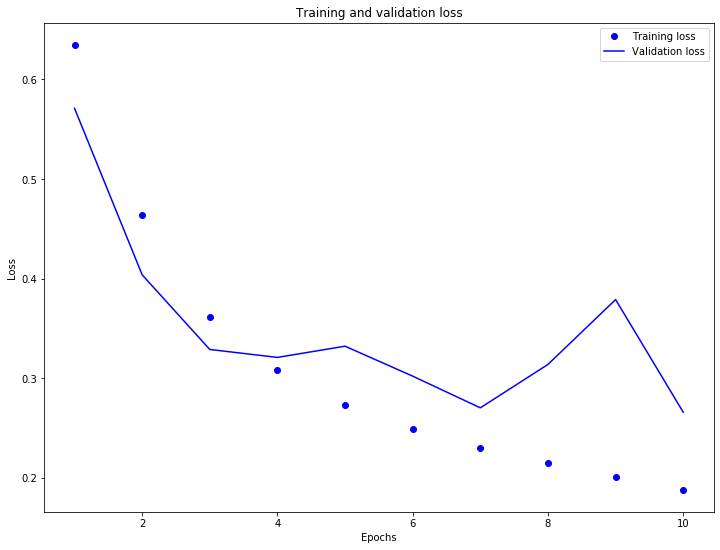

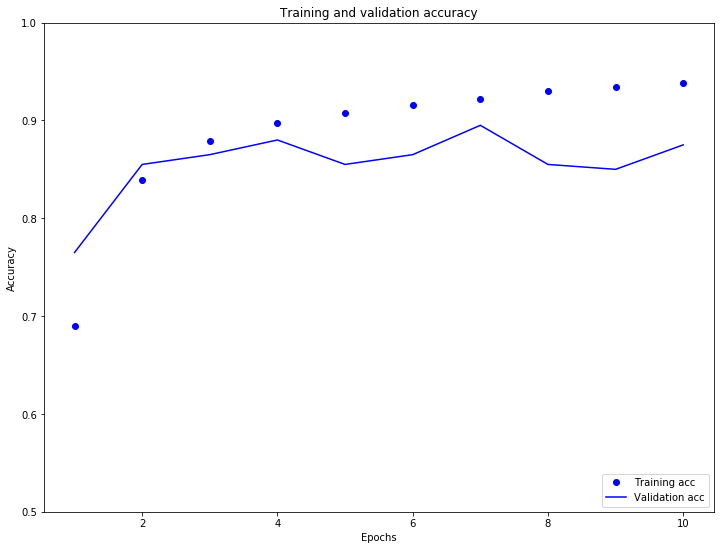

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


In [13]:
encoder = info.features['text'].encoder

In [14]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]  # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Open the [Embedding Projector](http://projector.tensorflow.org/)

http://projector.tensorflow.org/